# Import Dependencies

In [1]:
import time
import re
import pickle
import string
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import displacy, lemmatizer

from gensim.models import word2vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
# sklearn implements t-SNE.
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt

# Custom functions from .py files
from web_scrape import get_transcript
from preprocess import clean, preprocess

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


# Import/Preprocess Data

In [2]:
# Web scrape most recent speeches using our imported 'get_transcript'
goodyear_az = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-goodyear-az-october-28')
bullhead_az = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-bullhead-city-az-october-28')
omaha_ne = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-omaha-ne-october-27')
wsalem_wi = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-west-salem-wisconsin-october-27')
lansing_mi = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lansing-michigan-october-27')
martinsburg_pa = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-martinsburg-pa-october-26')
lititz_pa = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-lititz-pa-october-26')
allentown_pa = get_transcript('https://www.rev.com/blog/transcripts/donald-trump-rally-speech-transcript-allentown-pa-october-26')

In [3]:
# Create corpus for each state
az = [goodyear_az, bullhead_az]
ne = [omaha_ne]
wi = [wsalem_wi]
mi = [lansing_mi]
pa = [martinsburg_pa, lititz_pa, allentown_pa]

In [4]:
# Clean state corpuses
clean_az = clean(az)
clean_ne = clean(ne)
clean_wi = clean(wi)
clean_mi = clean(mi)
clean_pa = clean(pa)

In [5]:
# Preprocess our state corpuses
processed_az = preprocess(clean_az)
processed_ne = preprocess(clean_ne)
processed_wi = preprocess(clean_wi)
processed_mi = preprocess(clean_mi)
processed_pa = preprocess(clean_pa)

In [6]:
# Create corpus of all speeches
corpus = [goodyear_az, bullhead_az, omaha_ne, wsalem_wi, lansing_mi, martinsburg_pa, lititz_pa, allentown_pa]

In [7]:
# Clean all of the speeches in the corpus using our imported 'clean' function
clean_corpus = clean(corpus)

In [8]:
# Preprocess the speeches using our imported 'preprocess' function
processed_corpus = preprocess(clean_corpus)

# Document-Term Matrices

In [9]:
# Countvectorizer, make dataframes

cv_az = CountVectorizer(stop_words='english')
cv_ne = CountVectorizer(stop_words='english')
cv_wi = CountVectorizer(stop_words='english')
cv_mi = CountVectorizer(stop_words='english')
cv_pa = CountVectorizer(stop_words='english')

X_az = cv_az.fit_transform(processed_az)
df_az = pd.DataFrame(X_az.toarray(), columns=cv_az.get_feature_names())

X_ne = cv_ne.fit_transform(processed_ne)
df_ne = pd.DataFrame(X_ne.toarray(), columns=cv_ne.get_feature_names())

X_wi = cv_wi.fit_transform(processed_wi)
df_wi = pd.DataFrame(X_wi.toarray(), columns=cv_wi.get_feature_names())

X_mi = cv_mi.fit_transform(processed_mi)
df_mi = pd.DataFrame(X_mi.toarray(), columns=cv_mi.get_feature_names())

X_pa = cv_pa.fit_transform(processed_pa)
df_pa = pd.DataFrame(X_pa.toarray(), columns=cv_pa.get_feature_names())

In [10]:
# Add 'State' column to each dataframe
df_az['State'] = [0] * len(df_az) # AZ
df_ne['State'] = [1] * len(df_ne) # NE
df_wi['State'] = [2] * len(df_wi) # WI
df_mi['State'] = [3] * len(df_mi) # MI
df_pa['State'] = [4] * len(df_pa) # PA

In [11]:
# Concatenate the state dataframes into one and fillnas with 0
df = pd.concat([df_az, df_ne, df_wi, df_mi, df_pa])
df.fillna(0, inplace=True)

In [12]:
# Define features (words/vocab) and target (state), convert to numpys, and center (PCA only)
X = df.loc[:, df.columns != 'State']
X = X.to_numpy()
X_centered = X - X.mean()

y = df['State']

# PCA

In [ ]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X_centered)
pcafeatures = pca.transform(X_centered)

In [ ]:
# Create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

In [ ]:
# plot of all the numbers
plot_PCA_2D(pcafeatures, target=y, target_names=['AZ', 'NE', 'WI', 'MI', 'PA'])

In [ ]:
# Appears to be 3 clusters, with mixed state speeches in each. Arizona seems to be thye small cluster above

In [ ]:
# Instantiate PCA for all corpuses
pca = PCA(n_components=5)
pca_az = PCA(n_components=5)
pca_ne = PCA(n_components=5)
pca_wi = PCA(n_components=5)
pca_mi = PCA(n_components=5)
pca_pa = PCA(n_components=5)

In [ ]:
# Fit all PCAs
X = cv.fit_transform(processed_corpus)

pca_result = pca.fit_transform(X.toarray())
pca_az_result = pca_az.fit_transform(X_az.toarray())
pca_ne_result = pca_ne.fit_transform(X_ne.toarray())
pca_wi_result = pca_wi.fit_transform(X_wi.toarray())
pca_mi_result = pca_mi.fit_transform(X_mi.toarray())
pca_pa_result = pca_pa.fit_transform(X_pa.toarray())

In [ ]:
# Explained Variance
print(f"Count Vectorizer explained variance: {round(sum(pca.explained_variance_ratio_) * 100,4)}%")

In [ ]:
# to understand the importance of each variable in each PC, look at the correlations:
df_pca = pd.DataFrame(pca.components_, index = ['PC1','PC2', 'PC3', 'PC4', 'PC5'], columns=cv.get_feature_names())

In [ ]:
df_pca

## Scree plot

In [ ]:
pca2 = PCA(n_components=15)
pca2.fit(X.toarray())
pcafeatures2 = pca2.transform(X.toarray())

In [ ]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot');

In [ ]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for digits');

# t-SNE

In [13]:
# Define features (words/vocab) and target (state), convert to numpys
X = df.loc[:, df.columns != 'State']
X = X.to_numpy()
X_centered = X - X.mean()

y = df['State']

In [14]:
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Random state.
RS = 20200807

In [15]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([df[df.State==i]
               for i in range(5)])
y = np.hstack([df.State[df.State==i]
               for i in range(5)])

In [35]:
y

array([0, 0, 0, ..., 4, 4, 4])

In [32]:

tsne = TSNE(random_state=RS).fit_transform(X)

In [33]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 5))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(5):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 [Text(-60.50887, -2.7294607, '0'),
  Text(-32.05591, 2.8120441, '1'),
  Text(-10.866934, -31.78127, '2'),
  Text(3.7958593, 1.9280591, '3'),
  Text(41.105354, 11.760567, '4')])

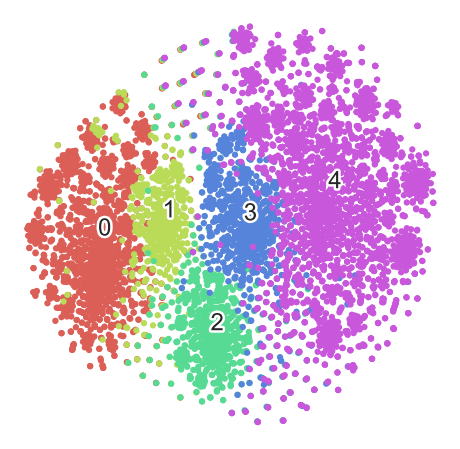

In [34]:
scatter(tsne, y)